<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Прогнозирование-заказов-такси" data-toc-modified-id="Прогнозирование-заказов-такси-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Прогнозирование заказов такси</a></span><ul class="toc-item"><li><span><a href="#Постановка-задачи" data-toc-modified-id="Постановка-задачи-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Постановка задачи</a></span></li><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Обучение моделей</a></span></li><li><span><a href="#Выбор-лучшей-модели" data-toc-modified-id="Выбор-лучшей-модели-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Выбор лучшей модели</a></span></li></ul></li></ul></div>

# Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо построить модель для такого предсказания.

## Постановка задачи

**Цель:**
 
Разработать модель, которая могла бы максимально точно прогнозировать спрос на такси.

**План работы:**
 
- Загрузить данные и выполнить их ресемплирование по одному часу
- Проанализировать данные
- Обучить разные модели с различными гиперпараметрами
- Проверить данные на тестовой выборке и сделать выводы

**Данные:** 
 
Данные предоставлены компанией "Четенькое такси". Количество заказов находится в столбце 'num_orders' (от англ. number of orders, «число заказов»).




## Подготовка данных

In [3]:
# импортируем необходимые библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib import rcParams, rcParamsDefault

from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from catboost import Pool, CatBoostRegressor, cv
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error

from sklearn.metrics import make_scorer

from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima 
from sklearn.model_selection import TimeSeriesSplit, cross_val_score

In [4]:
RS = 12345

In [5]:
data = pd.read_csv('taxi.csv')

In [6]:
display(data.head(5))

datetime  num_orders
0  2018-03-01 00:00:00           9
1  2018-03-01 00:10:00          14
2  2018-03-01 00:20:00          28
3  2018-03-01 00:30:00          20
4  2018-03-01 00:40:00          32

In [7]:
print(data.shape)

(26496, 2)


In [51]:
data.duplicated().sum()

0

In [52]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [53]:
data['datetime'] = data['datetime'].astype('datetime64')

In [54]:
data = data.set_index('datetime')


In [55]:
#ресемплирование
data = data.resample('1H').sum()
display(data.head(5))

num_orders
datetime                       
2018-03-01 00:00:00         124
2018-03-01 01:00:00          85
2018-03-01 02:00:00          71
2018-03-01 03:00:00          66
2018-03-01 04:00:00          43

## Анализ данных

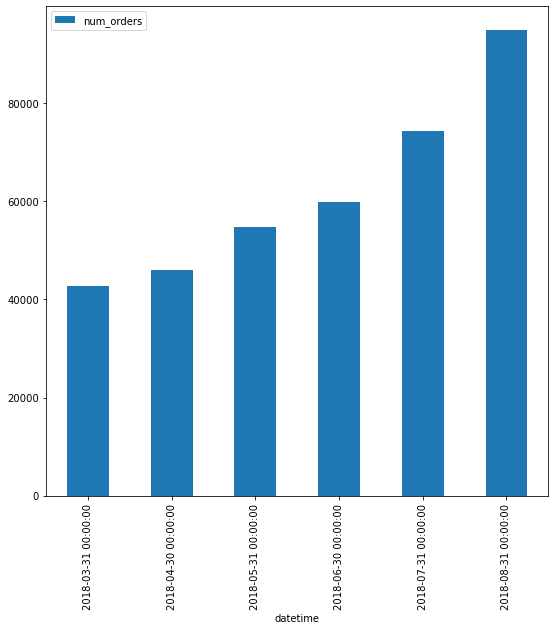

In [56]:
# посмотрим динамику в разные месяцы
data.resample('1M').sum().plot(kind='bar');

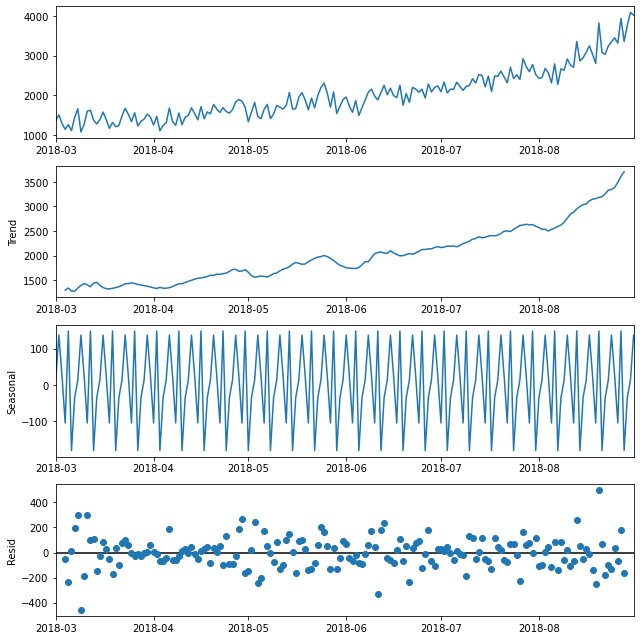

In [57]:
rcParams['figure.figsize'] = 9, 9
decompose = seasonal_decompose(data.resample('1D').sum())
decompose.plot()
plt.show()

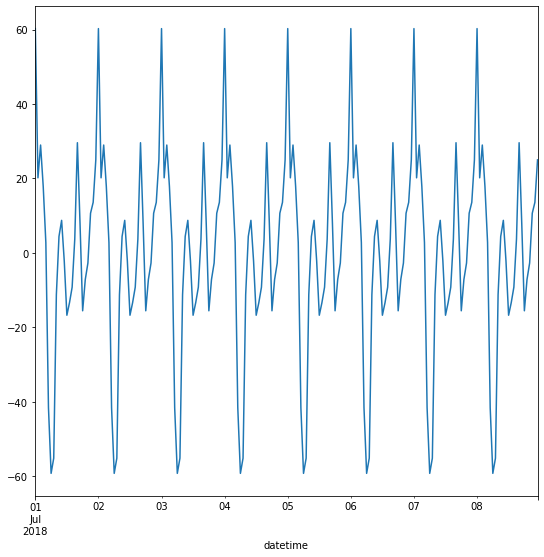

In [58]:
#сезонность на недельном отрезке
decompose_h = seasonal_decompose(data)
decomp_week = decompose_h.seasonal['2018-07-01':'2018-07-08']
decomp_week.plot()

plt.show()

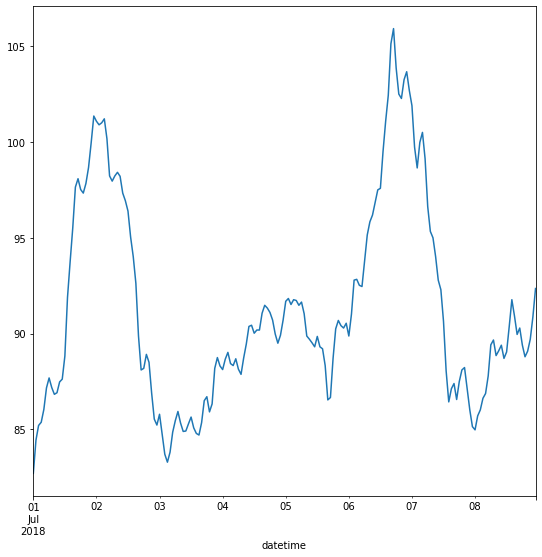

In [59]:
#тренд на недельном отрезке
decompose_h.trend['2018-07-01':'2018-07-08'].plot()
plt.show()

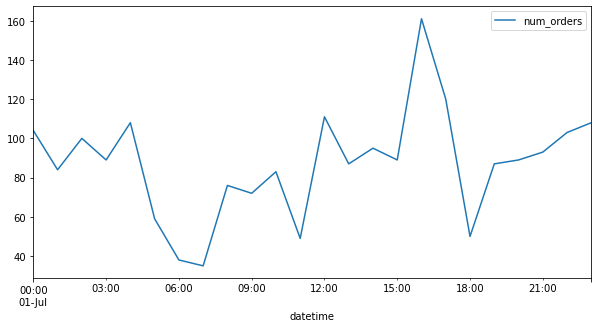

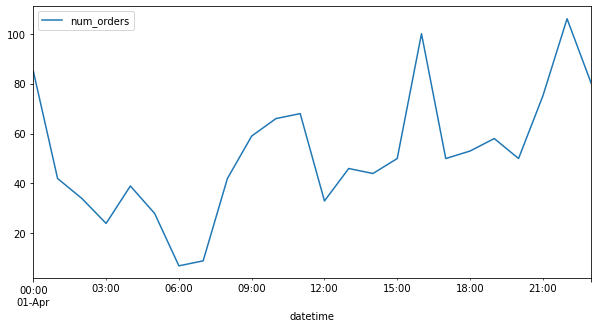

In [60]:
# Посмотрим, как выглядит один день в июле и один день в апреле
rcParams['figure.figsize'] = 10, 5
data['2018-07-01 00:00:00':'2018-07-01 23:00:00'].plot();
data['2018-04-01 00:00:00':'2018-04-01 23:00:00'].plot();


Можно заметить, что и в июле и в апреле есть резкое увеличение спроса в районе 18 часов. Я взяла именно июль и апрель, потому что в июле относительно высокий спрос, а в апреле не такой высокий. Можно оценить ситуацию и в туристические месяцы и в не очень туристические

In [61]:
# Исследуем стационарность 
#rcParams['figure.figsize'] = 8,4
from statsmodels.tsa.stattools import adfuller

adf_test = adfuller(data['num_orders'])
 
# выведем p-value
print('p-value = ' + str(adf_test[1]))

p-value = 0.0289400514026132


Для более точной оценки стационарности можно применить тест Дики-Фуллера (Dickey-Fuller test). Нужно выполнить статистическую проверку гипотезы. В данном случае гипотезы звучат следующим образом.

- Нулевая гипотеза предполагает, что процесс нестационарный (существует единичный корень, ряд нестационарный)
- Альтернативная гипотеза соответственно говорит об обратном (единичного корня нет, ряд стационарный)

Используем пороговое значение, равное 0.05 (5%).

Можно считать, что ряд стационарен, соотвественно, никаких преобразований не нужно проводить

In [62]:
data_day = data['2018-07-01 00:00:00':'2018-07-02 23:00:00']
data_day

num_orders
datetime                       
2018-07-01 00:00:00         104
2018-07-01 01:00:00          84
2018-07-01 02:00:00         100
2018-07-01 03:00:00          89
2018-07-01 04:00:00         108
2018-07-01 05:00:00          59
2018-07-01 06:00:00          38
2018-07-01 07:00:00          35
2018-07-01 08:00:00          76
2018-07-01 09:00:00          72
2018-07-01 10:00:00          83
2018-07-01 11:00:00          49
2018-07-01 12:00:00         111
2018-07-01 13:00:00          87
2018-07-01 14:00:00          95
2018-07-01 15:00:00          89
2018-07-01 16:00:00         161
2018-07-01 17:00:00         120
2018-07-01 18:00:00          50
2018-07-01 19:00:00          87
2018-07-01 20:00:00          89
2018-07-01 21:00:00          93
2018-07-01 22:00:00         103
2018-07-01 23:00:00         108
2018-07-02 00:00:00         188
2018-07-02 01:00:00         147
2018-07-02 02:00:00         126
2018-07-02 03:00:00         148
2018-07-02 04:00:00         151
2018-07-02 05:00:00          37
2018-07-02 06:00:00          33
2018-07-02 07:00:00          31
2018-07-02 08:00:00         104
2018-07-02 09:00:00          84
2018-07-02 10:00:00         133
2018-07-02 11:00:00          66
2018-07-02 12:00:00          81
2018-07-02 13:00:00         108
2018-07-02 14:00:00          79
2018-07-02 15:00:00         115
2018-07-02 16:00:00          85
2018-07-02 17:00:00         103
2018-07-02 18:00:00          54
2018-07-02 19:00:00          96
2018-07-02 20:00:00          89
2018-07-02 21:00:00          83
2018-07-02 22:00:00          71
2018-07-02 23:00:00         121

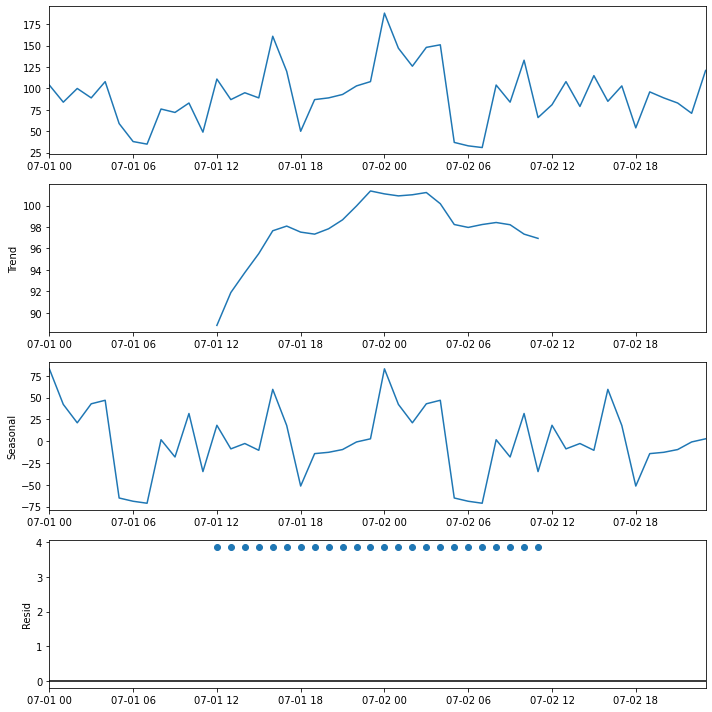

In [63]:
rcParams['figure.figsize'] = 10, 10
decompose_day = seasonal_decompose(data_day)
decompose_day.plot()
plt.show()

<div class="alert alert-block alert-info">
<b>Совет: </b> ОК, но, желательно было сначала првоести декомпозицию всего ряда, а затем взять подотрезок (лучше неделю).
</div>

<div class="alert alert-block alert-warning">
<b>Комментарий: </b> добавила выше
</div>

По тренду можно заметить ближе к вечеру (с 18 до 12 ночи) растет спрос и этот самое загруженное время для таксистов. По сезонности можно сказать, что утром в 6 утра резко падает спрос, затем возрастает ближе к 18 и 00.

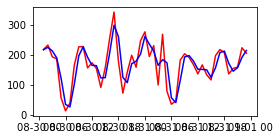

37.20937024517551


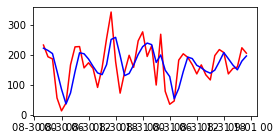

53.29049457074125


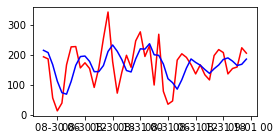

63.744498673306005


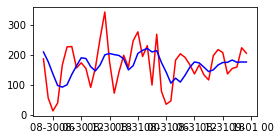

67.59614701230456


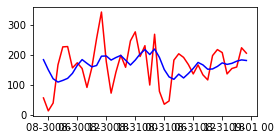

69.73090580801458


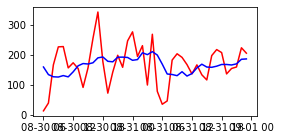

67.92390557450068


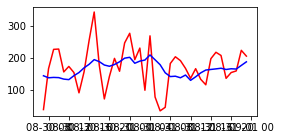

62.926871513977126


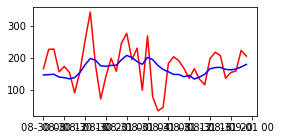

59.28822671627558


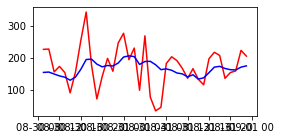

60.03829120033655


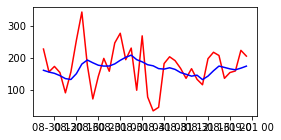

62.14800313100127


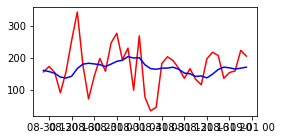

63.27369910554068


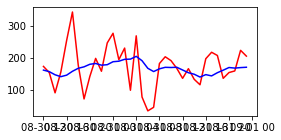

64.5242998632826


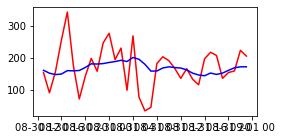

65.5193036785263


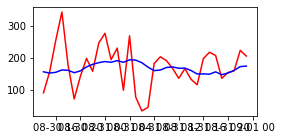

66.57033039492059


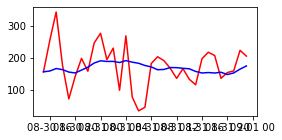

66.3901756391826


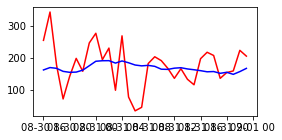

66.786833110948


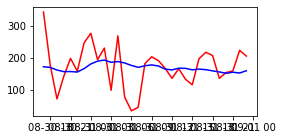

65.9555857159695


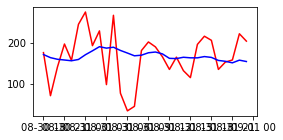

59.95063065843002


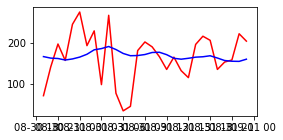

61.62310079608245


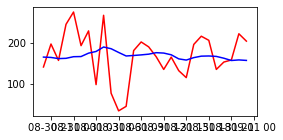

60.295350032185105


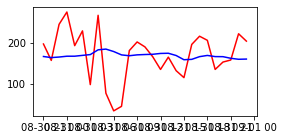

61.584824578009915


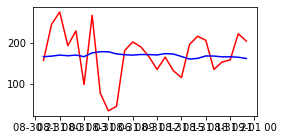

62.2411084136485


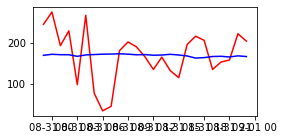

62.204006324173186


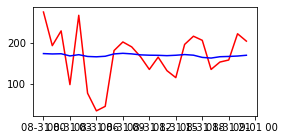

59.35472853951908


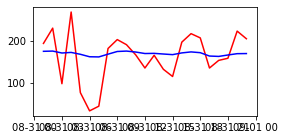

55.395072289503794


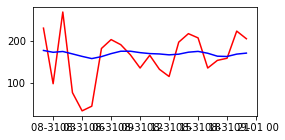

56.59878804647867


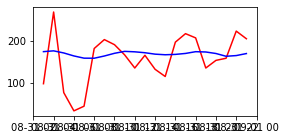

57.99764423770521


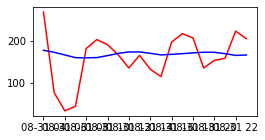

57.88077099016712


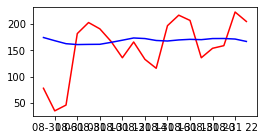

55.952374798698536


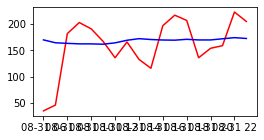

52.57135722880583


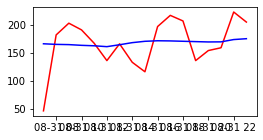

42.49692354782181


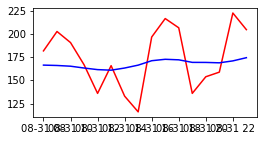

30.931430392629238


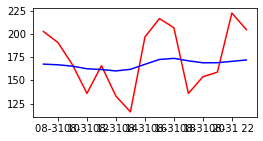

31.350481822389316


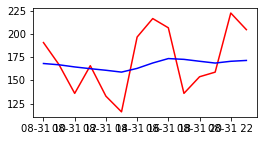

31.774131803954045


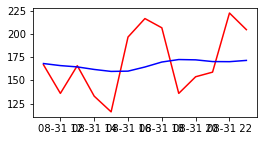

33.78557444177727


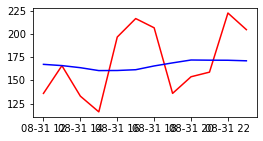

35.77340048315332


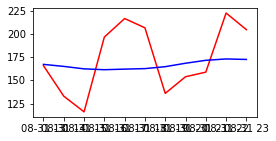

35.84313191905542


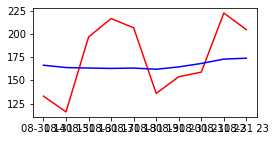

36.996836050019624


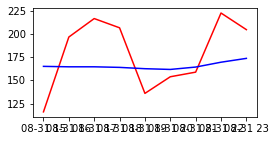

37.472419487167116


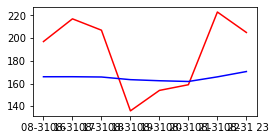

36.27573037059744


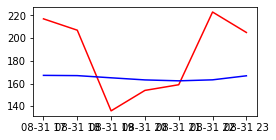

37.86404976996232


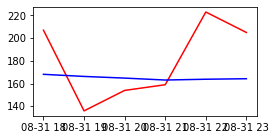

35.86913849604602


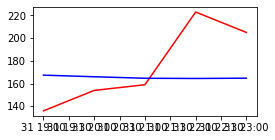

35.22933571671942


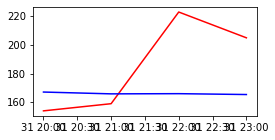

35.48519252996789


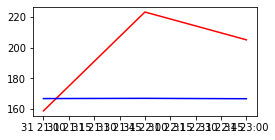

39.339261618971676


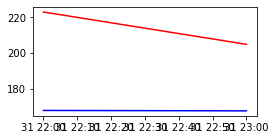

46.818502318507804


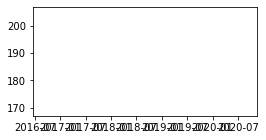

36.08333333333334


In [64]:
rcParams['figure.figsize'] = 4,2
rolling_mean_size_dict = {}
for rolling_mean_size in range(2,49):
    data_aug = data['2018-08-30':'2018-08-31'].copy()
    data_aug['rolling_mean'] = data_aug['num_orders'].rolling(rolling_mean_size).mean()
    data_aug.dropna(inplace=True)
    index = data_aug.index
    num_orders = data_aug['num_orders']
    rolling_mean = data_aug['rolling_mean']
    plt.plot(index,num_orders,'r-',index, rolling_mean,'b-')
    plt.show()
    RMSE = mean_squared_error(num_orders,rolling_mean)**0.5
    print(RMSE)
    rolling_mean_size_dict[rolling_mean_size] = RMSE

In [65]:
rolling_mean_size = min(rolling_mean_size_dict.keys(), key=(lambda x: rolling_mean_size_dict[x]))
rolling_mean_size

33

In [66]:
max_lag = 20

In [67]:
def make_features(data, column, max_lag, rolling_mean_size):
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['month'] = data.index.month
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data[column].shift(lag)

    data['rolling_mean'] = data[column].shift().rolling(rolling_mean_size).mean()

In [68]:
data_w_feat = data.copy()

In [69]:
make_features(data_w_feat,'num_orders', max_lag, rolling_mean_size)

In [70]:
data_w_feat = data_w_feat.dropna()

In [71]:
#data_w_feat.reset_index(inplace=True)
data_w_feat

num_orders  day  dayofweek  month  lag_1  lag_2  lag_3  \
datetime                                                                      
2018-03-02 09:00:00          45    2          4      3   46.0    7.0   11.0   
2018-03-02 10:00:00          54    2          4      3   45.0   46.0    7.0   
2018-03-02 11:00:00          91    2          4      3   54.0   45.0   46.0   
2018-03-02 12:00:00          36    2          4      3   91.0   54.0   45.0   
2018-03-02 13:00:00          45    2          4      3   36.0   91.0   54.0   
...                         ...  ...        ...    ...    ...    ...    ...   
2018-08-31 19:00:00         136   31          4      8  207.0  217.0  197.0   
2018-08-31 20:00:00         154   31          4      8  136.0  207.0  217.0   
2018-08-31 21:00:00         159   31          4      8  154.0  136.0  207.0   
2018-08-31 22:00:00         223   31          4      8  159.0  154.0  136.0   
2018-08-31 23:00:00         205   31          4      8  223.0  159.0  154.0   

                     lag_4  lag_5  lag_6  ...  lag_12  lag_13  lag_14  lag_15  \
datetime                                  ...                                   
2018-03-02 09:00:00   11.0   20.0   64.0  ...    66.0    61.0    45.0    73.0   
2018-03-02 10:00:00   11.0   11.0   20.0  ...   113.0    66.0    61.0    45.0   
2018-03-02 11:00:00    7.0   11.0   11.0  ...    58.0   113.0    66.0    61.0   
2018-03-02 12:00:00   46.0    7.0   11.0  ...    90.0    58.0   113.0    66.0   
2018-03-02 13:00:00   45.0   46.0    7.0  ...   120.0    90.0    58.0   113.0   
...                    ...    ...    ...  ...     ...     ...     ...     ...   
2018-08-31 19:00:00  116.0  133.0  166.0  ...    46.0    35.0    78.0   268.0   
2018-08-31 20:00:00  197.0  116.0  133.0  ...   182.0    46.0    35.0    78.0   
2018-08-31 21:00:00  217.0  197.0  116.0  ...   203.0   182.0    46.0    35.0   
2018-08-31 22:00:00  207.0  217.0  197.0  ...   191.0   203.0   182.0    46.0   
2018-08-31 23:00:00  136.0  207.0  217.0  ...   167.0   191.0   203.0   182.0   

                     lag_16  lag_17  lag_18  lag_19  lag_20  rolling_mean  
datetime                                                                   
2018-03-02 09:00:00    44.0    43.0    66.0    48.0    32.0     54.787879  
2018-03-02 10:00:00    73.0    44.0    43.0    66.0    48.0     52.393939  
2018-03-02 11:00:00    45.0    73.0    44.0    43.0    66.0     51.454545  
2018-03-02 12:00:00    61.0    45.0    73.0    44.0    43.0     52.060606  
2018-03-02 13:00:00    66.0    61.0    45.0    73.0    44.0     51.151515  
...                     ...     ...     ...     ...     ...           ...  
2018-08-31 19:00:00    99.0   230.0   194.0   276.0   246.0    172.333333  
2018-08-31 20:00:00   268.0    99.0   230.0   194.0   276.0    169.575758  
2018-08-31 21:00:00    78.0   268.0    99.0   230.0   194.0    169.515152  
2018-08-31 22:00:00    35.0    78.0   268.0    99.0   230.0    169.090909  
2018-08-31 23:00:00    46.0    35.0    78.0   268.0    99.0    171.181818  

[4383 rows x 25 columns]

## Обучение моделей

In [72]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [73]:
rmse_scorer = make_scorer(rmse,greater_is_better=False)

In [75]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)

In [76]:
train = train.dropna()

In [78]:
model = auto_arima(y = train, m=24)

In [85]:
predictions = pd.Series(model.predict(n_periods = 442))
predictions

2018-08-13 14:00:00    114.411423
2018-08-13 15:00:00    145.244013
2018-08-13 16:00:00    149.312266
2018-08-13 17:00:00    125.423515
2018-08-13 18:00:00     98.926245
                          ...    
2018-08-31 19:00:00    134.086303
2018-08-31 20:00:00    134.086791
2018-08-31 21:00:00    134.087879
2018-08-31 22:00:00    134.087396
2018-08-31 23:00:00    134.089304
Freq: H, Length: 442, dtype: float64

<function matplotlib.pyplot.show(*args, **kw)>

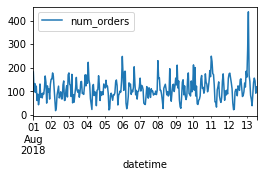

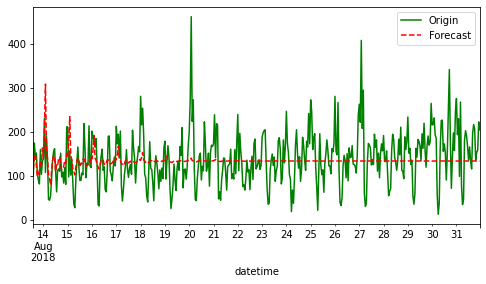

In [86]:
train['2018-08'].plot(label='Original')
test.plot(label='Test', color='green')
predictions.plot(label='Forecast', figsize=(8,4), style='--', color='red')
plt.legend(['Origin', 'Forecast' ])
plt.show

In [87]:
test

num_orders
datetime                       
2018-08-13 14:00:00         102
2018-08-13 15:00:00         175
2018-08-13 16:00:00         144
2018-08-13 17:00:00         152
2018-08-13 18:00:00         104
...                         ...
2018-08-31 19:00:00         136
2018-08-31 20:00:00         154
2018-08-31 21:00:00         159
2018-08-31 22:00:00         223
2018-08-31 23:00:00         205

[442 rows x 1 columns]

In [89]:
from sklearn.metrics import mean_squared_error
mean_squared_error(test, predictions, squared=False)

57.87611358393554

In [90]:
train, test = train_test_split(data_w_feat, shuffle=False, test_size=0.1)

In [91]:
X_train = train.drop(columns='num_orders')
y_train = train['num_orders']

X_test = test.drop(columns='num_orders')
y_test = test['num_orders']



In [93]:
# TimeSeriesSplit
splits = TimeSeriesSplit(n_splits=5)
# RandomForest
RF = RandomForestRegressor(random_state=RS)
parametrs = {"max_depth": range(5,25),"n_estimators":range(10,50)}

RF_grid = RandomizedSearchCV(RF,parametrs,cv = splits,verbose=True,scoring=rmse_scorer,n_jobs=-1)
RF_grid.fit(X_train,y_train)



Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=RandomForestRegressor(random_state=12345),
                   n_jobs=-1,
                   param_distributions={'max_depth': range(5, 25),
                                        'n_estimators': range(10, 50)},
                   scoring=make_scorer(rmse, greater_is_better=False),
                   verbose=True)

In [94]:
# CatBoost
catboost = CatBoostRegressor(random_state = RS)
params_cat = {'depth':[5,10], 'learning_rate':np.arange(0.1,1,0.2)}
cat_grid = RandomizedSearchCV(catboost, params_cat, cv=splits,verbose=True,scoring=rmse_scorer)

In [95]:
cat_grid.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
0:	learn: 28.5304448	total: 56.3ms	remaining: 56.3s
1:	learn: 27.6331431	total: 57.6ms	remaining: 28.8s
2:	learn: 26.8820825	total: 58.8ms	remaining: 19.5s
3:	learn: 26.0969533	total: 60ms	remaining: 14.9s
4:	learn: 25.3913508	total: 60.9ms	remaining: 12.1s
5:	learn: 24.7897368	total: 61.8ms	remaining: 10.2s
6:	learn: 24.3358261	total: 62.7ms	remaining: 8.89s
7:	learn: 23.6970262	total: 63.6ms	remaining: 7.88s
8:	learn: 23.2477501	total: 64.5ms	remaining: 7.11s
9:	learn: 22.7822348	total: 65.5ms	remaining: 6.48s
10:	learn: 22.3978069	total: 66.4ms	remaining: 5.97s
11:	learn: 22.0688753	total: 67.3ms	remaining: 5.54s
12:	learn: 21.7480714	total: 68.3ms	remaining: 5.18s
13:	learn: 21.3860028	total: 69.2ms	remaining: 4.88s
14:	learn: 21.0714096	total: 70.2ms	remaining: 4.61s
15:	learn: 20.7815293	total: 71.3ms	remaining: 4.38s
16:	learn: 20.5869568	total: 72.2ms	remaining: 4.17s
17:	learn: 20.3446720	total: 73.1ms	remaining: 3.9

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=<catboost.core.CatBoostRegressor object at 0x7fd03a2cebb0>,
                   param_distributions={'depth': [5, 10],
                                        'learning_rate': array([0.1, 0.3, 0.5, 0.7, 0.9])},
                   scoring=make_scorer(rmse, greater_is_better=False),
                   verbose=True)

In [96]:
RF_grid.best_score_*(-1)

28.554034059648405

In [97]:
model_RF = RF_grid.best_estimator_

In [98]:
grid_res = pd.DataFrame(RF_grid.cv_results_).sort_values(by='rank_test_score')

In [99]:
grid_res.iloc[0]['mean_fit_time'], grid_res.iloc[0]['mean_score_time']

(2.344440984725952, 0.02397575378417969)

In [100]:
cat_grid.best_score_*(-1)


27.766547308854143

In [101]:
model_CB = cat_grid.best_estimator_

In [102]:
grid_res = pd.DataFrame(cat_grid.cv_results_).sort_values(by='rank_test_score')

In [103]:
grid_res.iloc[0]['mean_fit_time'], grid_res.iloc[0]['mean_score_time']

(2.1060626983642576, 0.004093837738037109)

Тк показатели у CB лучше протестируем ее еще и на тестовых данных.

In [104]:
predicted = model_CB.predict(X_test)
score = rmse(predicted, y_test)
print(score)

47.37433324332529


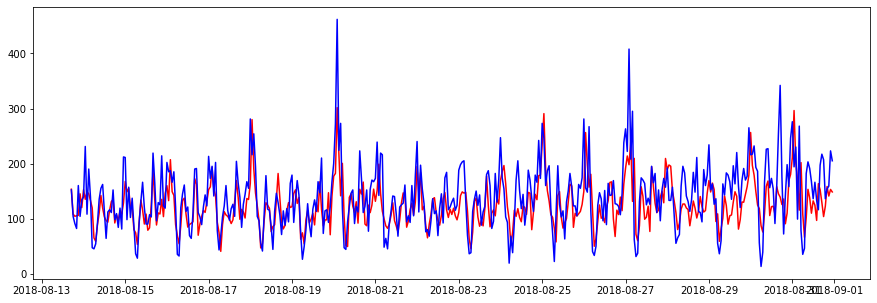

In [106]:
plt.subplots(figsize=(15, 5))
x=y_test.index
y1=predicted
y2=y_test
plt.plot(x, y1, color='red')
plt.plot(x, y2, color='blue')
#plt.xlim(['2018-08-24', '2018-08-27'])
plt.show()

## Выбор лучшей модели

**Вывод:**  Самой подхрдящей моделью для нашей задачи оказалась catboost. Ее метрика меньше 48, она быстро обучается.